# TP1 - Grupo 4 - Pasajeros

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
import scipy.stats
import pylab
import statsmodels.tsa.stattools as tsa

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')

  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Serie 1: Residentes')
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title='Repito grafico: Residentes')
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

# Pasajeros 

Pasajeros por línea a partir del 30 de septiembre del 2021

In [3]:
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Pasajeros_TP.csv'
pasajeros_d = pd.read_csv(url)
pasajeros_d.rename({'FechaRecaudacion': 'fecha', 'Cantidad_Pasajeros': 'pas'}, axis=1,inplace=True)

In [4]:
# Para la fecha jueves 13 de octubre del 2022, se observa el valor de 1 y para corregir este dato se optó por sacar el promedio de los dos dias posteriores y el valor del día anterior.
# Además se agregan las observaciones que corresponden a los días 2022-05-17, 2022-10-12 y 2023-06-13 con el valor de 1, posteriormente se reemplaza este valor por el promedio de los dos dias posteriores y el valor del día anterior.
# Agregar fechas faltantes
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'pas': 1},
                                     {'fecha': '2022-10-12', 'pas': 1},
                                     {'fecha': '2023-06-13', 'pas': 1}])
pasajeros_d = pd.concat([pasajeros_d, nuevas_observaciones], ignore_index=True)

In [5]:
# Ordenar el DataFrame por la columna de fechas
pasajeros_d = pasajeros_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
pasajeros_d = pasajeros_d.reset_index(drop=True)

In [6]:
# Convertir la columna 'Fecha' a tipo datetime
pasajeros_d['fecha'] = pd.to_datetime(pasajeros_d['fecha'])

# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_17 = (pasajeros_d.loc[index_to_replace - 1, 'pas'] + pasajeros_d.loc[index_to_replace + 1, 'pas'] + pasajeros_d.loc[index_to_replace + 2, 'pas']) / 3

# Redondear el promedio con 0 decimales
average_value_17 = round(average_value_17, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_17

In [7]:
# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (pasajeros_d.loc[index_to_replace - 1, 'pas'] + pasajeros_d.loc[index_to_replace + 1, 'pas'] + pasajeros_d.loc[index_to_replace + 2, 'pas']) / 3

# Redondear el promedio con 0 decimales
average_value_12 = round(average_value_12, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_12

In [8]:
# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (pasajeros_d.loc[index_to_replace - 2, 'pas'] + pasajeros_d.loc[index_to_replace + 1, 'pas'] + pasajeros_d.loc[index_to_replace + 2, 'pas']) / 3

# Redondear el promedio con 0 decimales
average_value_13 = round(average_value_13, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_13

In [9]:
# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (pasajeros_d.loc[index_to_replace - 1, 'pas'] + pasajeros_d.loc[index_to_replace + 1, 'pas'] + pasajeros_d.loc[index_to_replace + 2, 'pas']) / 3

# Redondear el promedio con 0 decimales
average_value_6 = round(average_value_6, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_6

In [10]:
# Formato a la variable Fecha
pasajeros_d['fecha'] = pd.to_datetime(pasajeros_d['fecha'])

# Formato diario
pasajeros_d.set_index('fecha', inplace=True)

pasajeros_d.head()

,pas
fecha,
2021-09-30,153297
2021-10-01,163933
2021-10-02,71862
2021-10-03,41802
2021-10-04,159940


In [11]:
pasajeros_d.describe()

,pas
count,760.000000
mean,175654.151316
std,82374.915109
min,5582.000000
25%,106144.500000
50%,178092.500000
75%,249031.500000
max,319953.000000


Text(0.5, 1.0, 'Histograma de la cantidad de pasajeros por día')

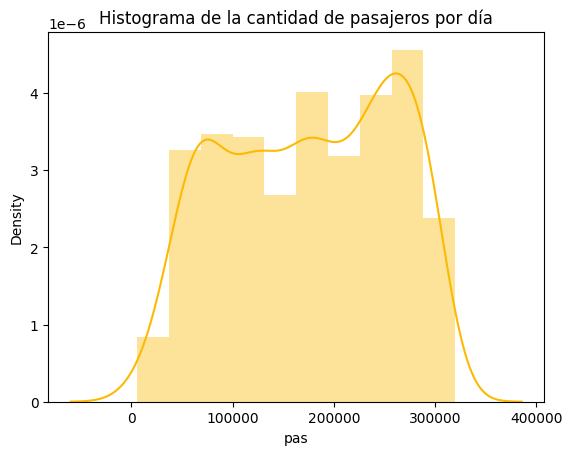

In [12]:
sns.distplot(pasajeros_d.pas,bins=10,color='#fcba03')
plt.title('Histograma de la cantidad de pasajeros por día')

# Pregunta 2

Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie.

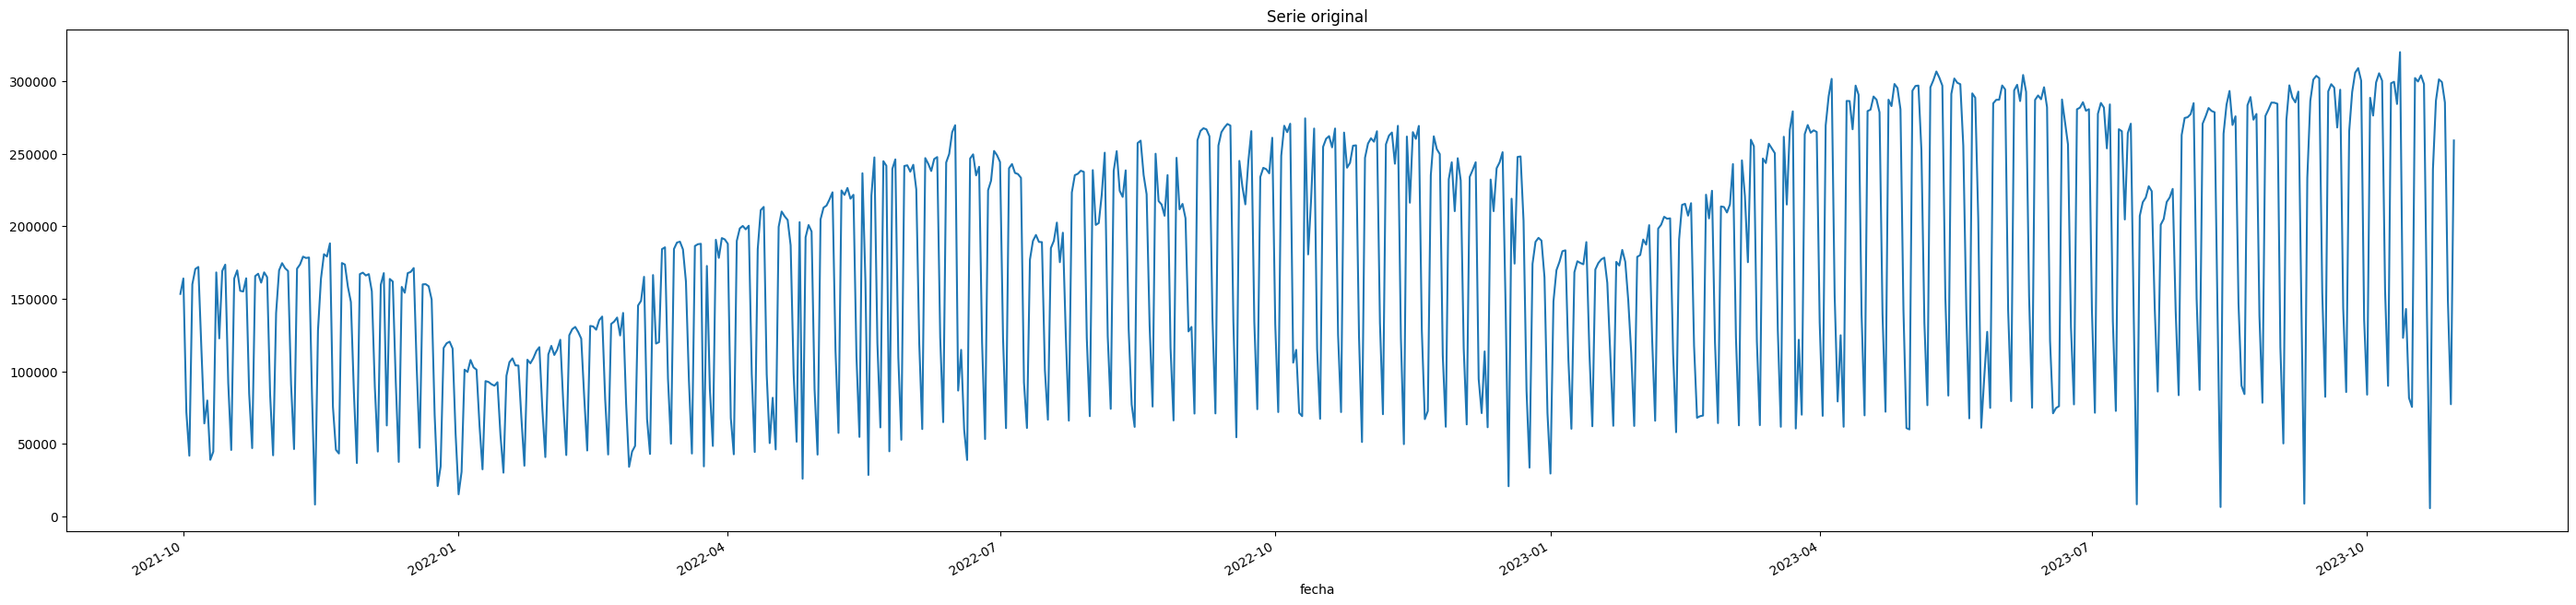

In [13]:
# Pasajeros
pasajeros_d.pas.plot(figsize=(35,8), title = 'Serie original');

# Pregunta 3

Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría

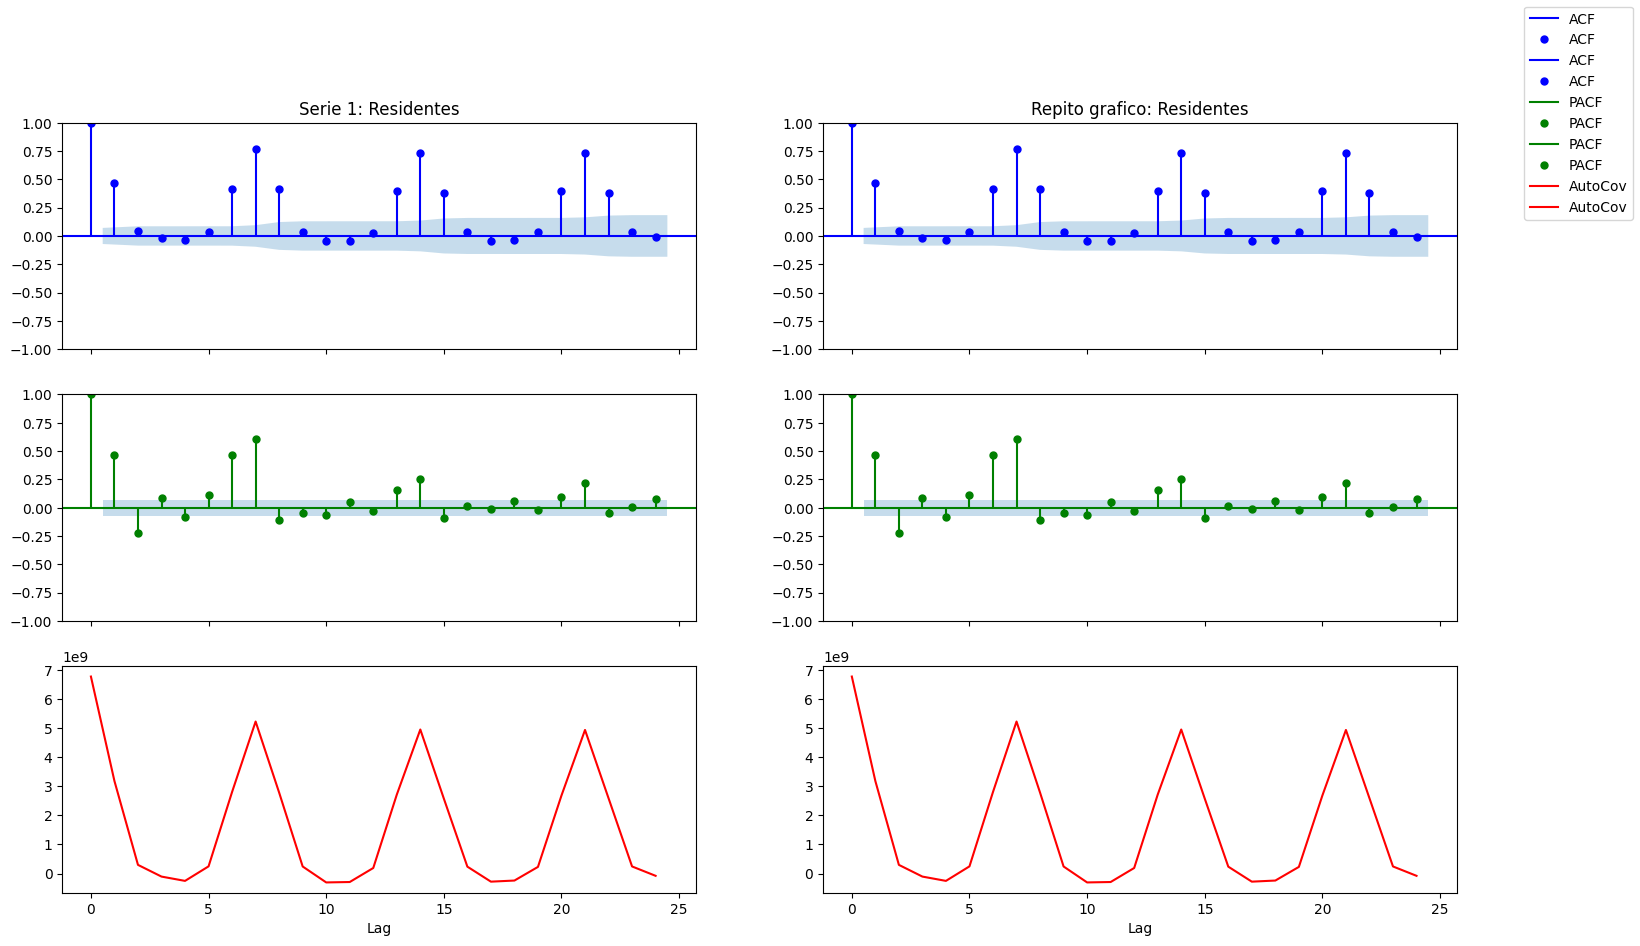

In [14]:
# Grafica diferentes funciones de la serie Pasajeros
autocov_autocorr(pasajeros_d, pasajeros_d, 24)

# Pregunta 4

Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

# Pregunta 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual global de los parámetros del modelo).

# Pregunta 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

# Pregunta 7

Detallar una comparación con otros modelos estimados

# Pregunta 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

# Pregunta 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

# Pregunta 10

Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.

# Pregunta 11

Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad. Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis.

# Pregunta 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior. 

Opcional: Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.